# MNIST Handwriten Digits Classifier

In [19]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
model_root_dir = '/notebooks/my-notebooks/MNIST/'

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets(model_root_dir+'MNIST_data', one_hot=True)

Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/train-labels-idx1-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting /notebooks/my-notebooks/MNIST/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
image_size = 28
num_classes = 10
embedding_size = 256

In [4]:
batch_size = 100
learning_rate = 0.2
keep_prob = 0.6

epochs = 2
iterations = mnist.train.num_examples//batch_size

In [5]:
model_logdir = model_root_dir+'logdir/'

LABELS = os.path.join(os.getcwd(), model_logdir+"labels_1024.tsv")
SPRITES = os.path.join(os.getcwd(), model_logdir+"sprite_1024.png")

hparam_str = 'c2,fc2,lr_%f' % (learning_rate)
previous_runs = list(f for f in os.listdir(model_logdir) if f.startswith('run'))

if len(previous_runs) == 0:
    run_number = 1  
else:
    run_number = max([int(s[4:6]) for s in previous_runs]) + 1

LOGDIR = '%srun_%02d,' % (model_logdir, run_number)+hparam_str

In [6]:
tf.reset_default_graph()

In [7]:
with tf.name_scope('input'):
    X_placeholder = tf.placeholder(shape=[None, image_size**2], dtype=tf.float32, name='X_placeholder')
    Y_placeholder = tf.placeholder(shape=[None, num_classes], dtype=tf.int64, name='Y_placeholder')

with tf.name_scope('dropout_keep_prob'):
    dropout_keep_prob = tf.placeholder(shape=(), dtype=tf.float32)

with tf.name_scope('input_reshaped'):
    X_image = tf.reshape(X_placeholder, [-1,image_size,image_size,1])
    tf.summary.image('input', X_image, 1)

In [8]:
def variable_summaries(var):
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram('histogram', var)

In [9]:
with tf.name_scope('conv1'):
    
    with tf.name_scope('Weights'):
        W_conv1 = tf.Variable(tf.truncated_normal([5, 5, 1, 8], stddev=0.1),dtype=tf.float32)
        variable_summaries(W_conv1)
        
        with tf.name_scope('visualize_weights'):
            W_conv1_image = tf.transpose(W_conv1,perm=[3,0,1,2])
            tf.summary.image("Visualize_kernels_conv1", W_conv1_image, max_outputs=8)
        
    with tf.name_scope('biases'):
        b_conv1 = tf.Variable(tf.constant(0.1,shape=[8]),dtype=tf.float32)
        variable_summaries(b_conv1)
    
    with tf.name_scope('convolution'):
        
        preactivated = tf.nn.conv2d(X_image, W_conv1,
                                    strides=[1, 1, 1, 1],
                                    padding='SAME') + b_conv1
        
        activated = tf.nn.relu(preactivated)
        
        tf.summary.histogram('pre_activations', preactivated)
        tf.summary.histogram('activations', activated)
        
    with tf.name_scope('max_pooling'):
        pool1 =  tf.nn.max_pool(activated,
                                ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1],
                                padding='SAME')
        
    with tf.name_scope('image_output_conv1'):
        image = activated[0:1, :, :, :]
        image = tf.transpose(image, perm=[3,1,2,0])
        tf.summary.image('image_output_conv1', image,max_outputs=8)

In [10]:
with tf.name_scope('conv2'):
    
    with tf.name_scope('Weights'):
        W_conv2 = tf.Variable(tf.truncated_normal([5, 5, 8, 16], stddev=0.1),dtype=tf.float32)
        variable_summaries(W_conv2)
        
        with tf.name_scope('visualize_weights'):
            W_conv2_image = tf.transpose(W_conv2,perm=[3,0,1,2])[:,:,:,0:1]
            tf.summary.image("Visualize_kernels_conv2", W_conv2_image, max_outputs=16)
            
    with tf.name_scope('biases'):
        b_conv2 = tf.Variable(tf.constant(0.1,shape=[16]),dtype=tf.float32)
        variable_summaries(b_conv2)
    
    with tf.name_scope('convolution'):
        
        preactivated = tf.nn.conv2d(pool1, W_conv2,
                                    strides=[1, 1, 1, 1],
                                    padding='SAME') + b_conv2
        
        activated = tf.nn.relu(preactivated)
        
        tf.summary.histogram('pre_activations', preactivated)
        tf.summary.histogram('activations', activated)
        
    with tf.name_scope('max_pooling'):
        pool2 =  tf.nn.max_pool(activated,
                                ksize=[1, 2, 2, 1],
                                strides=[1, 2, 2, 1],
                                padding='SAME')
        
    with tf.name_scope('image_output_conv2'):
        image = activated[0:1, :, :, :]
        image = tf.transpose(image, perm=[3,1,2,0])
        tf.summary.image('image_output_conv2',image,max_outputs=16)

In [11]:
with tf.name_scope('fully_connected'):
    with tf.name_scope('Weights'):
        W_fc1 = tf.Variable(tf.truncated_normal([7*7*16, 256], stddev=0.1),dtype=tf.float32)
        variable_summaries(W_fc1)
    with tf.name_scope('biases'):
        b_fc1 = tf.Variable(tf.constant(0.1,shape=[256]),dtype=tf.float32)
        variable_summaries(b_fc1)
    with tf.name_scope('flatten'):
        pool2_flat = tf.reshape(pool2,[-1, 7*7*16])
    with tf.name_scope('Wx_plus_b'):
        fc1 = tf.nn.relu(tf.matmul(pool2_flat, W_fc1) + b_fc1)
    with tf.name_scope('dropout'):
        fc1_dropout = tf.nn.dropout(fc1, keep_prob=dropout_keep_prob)
    embedding_input = fc1

with tf.name_scope('output_layer'):
    with tf.name_scope('Weights'):
        W_fc2 = tf.Variable(tf.truncated_normal([256, num_classes], stddev=0.1),dtype=tf.float32)
        variable_summaries(W_fc2)
    with tf.name_scope('biases'):
        b_fc2 = tf.Variable(tf.constant(0.1,shape=[num_classes]),dtype=tf.float32)
        variable_summaries(b_fc2)
    with tf.name_scope('predictions'):
        Y_predictions = tf.matmul(fc1_dropout, W_fc2) + b_fc2

In [12]:
with tf.name_scope('loss'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=Y_placeholder,
                                                               logits=Y_predictions,
                                                               name='cross_entropy')
    
    loss = tf.reduce_mean(cross_entropy)
    tf.summary.scalar('loss', loss)

with tf.name_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

In [13]:
with tf.name_scope('accuracy'):
    with tf.name_scope('correct_predictions'):
        correct_prediction = tf.equal(tf.argmax(Y_predictions, 1), tf.argmax(Y_placeholder, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar('accuracy', accuracy)

In [14]:
sess = tf.InteractiveSession()

In [15]:
summ = tf.summary.merge_all()

embedding = tf.Variable(tf.zeros([1024, embedding_size]), name="embeddings")
assignment = embedding.assign(embedding_input)

saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())

writer = tf.summary.FileWriter(LOGDIR)
writer.add_graph(sess.graph)

config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
embedding_config = config.embeddings.add()
embedding_config.tensor_name = embedding.name
embedding_config.sprite.image_path = SPRITES
embedding_config.metadata_path = LABELS
embedding_config.sprite.single_image_dim.extend([image_size, image_size])
tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

In [16]:
losses = np.array([])

for epoch in range(epochs):
    
    print('New epoch', str(epoch+1)+'/'+str(epochs))

    for idx in range(iterations):

        batch_xs, batch_ys = mnist.train.next_batch(batch_size, shuffle=True)

        _, _loss, _summary = sess.run([train_step, loss, summ], 
                                      feed_dict={
                                          X_placeholder: batch_xs,
                                          Y_placeholder: batch_ys,
                                          dropout_keep_prob : keep_prob
                                      })

        if (idx+1) % (iterations/5) == 0:

            _test_summary, _accuracy = sess.run([summ, accuracy], feed_dict={X_placeholder : mnist.validation.images,
                                                      Y_placeholder : mnist.validation.labels,
                                                      dropout_keep_prob : 1.0
                                                     })

            print('step', str(idx+1)+'/'+str(iterations), 'loss', _loss, 'accuracy', str(round(100*_accuracy,2))+'%')

        if idx % 10 == 0:
            writer.add_summary(_summary, (epoch*iterations)+idx)
            
        losses = np.append(losses, _loss)

    sess.run(assignment, feed_dict={X_placeholder: mnist.test.images[:1024], Y_placeholder: mnist.test.labels[:1024]})
    saver.save(sess, os.path.join(LOGDIR, "model.ckpt"), (epoch*iterations)+idx)

New epoch 1/2
step 110/550 loss 0.27876318 accuracy 94.44%
step 220/550 loss 0.22014453 accuracy 95.72%
step 330/550 loss 0.14679919 accuracy 97.28%
step 440/550 loss 0.131384 accuracy 97.34%
step 550/550 loss 0.16665985 accuracy 97.24%
New epoch 2/2
step 110/550 loss 0.2563983 accuracy 98.1%
step 220/550 loss 0.1000606 accuracy 98.1%
step 330/550 loss 0.12171142 accuracy 98.1%
step 440/550 loss 0.09272071 accuracy 98.16%
step 550/550 loss 0.062768295 accuracy 98.36%


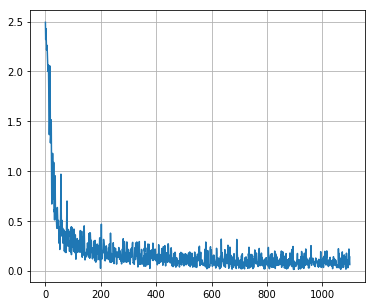

In [17]:
fig, ax = plt.subplots(figsize=(6,5))
ax.plot(losses)
ax.grid(True)

In [18]:
_accuracy = sess.run(accuracy, feed_dict={X_placeholder : mnist.test.images,
                                          Y_placeholder : mnist.test.labels,
                                          dropout_keep_prob : 1.0
                                         })

print(str(round(100*_accuracy,2))+'%')

98.34%
